<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/template%20Series%20temporales/Suavizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suavizado de series temporales

## Importación de datos

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

# carga de archivo
raw_csv_data = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Frecuencia%20inscripciones/data/conversionesPE.csv", index_col=0)

raw_csv_data.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,FechaConsultora,FuenteIngreso,cantidad,Pais
1,26/08/19,MovilGZ,33,Perú
2,10/03/19,CALL CENTER,1,Perú
3,04/11/19,MovilGZ,30,Perú
4,13/02/19,UB,31,Perú
5,04/11/19,CALL CENTER,4,Perú


### Transformación y formateo de datos

> Bloque con sangría



In [27]:
df_comp = raw_csv_data.copy()

df_comp=df_comp[df_comp.FuenteIngreso == "UB"]
# formateo de fecha 
df_comp['Fecha'] = pd.to_datetime(raw_csv_data.FechaConsultora, dayfirst = True)
df_comp = df_comp.groupby(['Fecha']).sum().reset_index()

#df_comp.set_index('Fecha', inplace=True, verify_integrity=True)
#df_comp.index = pd.DatetimeIndex(df_comp.index).to_period('d')

dateColumnName = "Fecha"
analizedValue = "cantidad"
unused_columns = ['cantidad']

#creacion de indice fecha
df_comp.set_index(dateColumnName, inplace=True, verify_integrity=True)
df_comp=df_comp.asfreq('d')
df_comp=df_comp.fillna(method='ffill')

df_comp['analizedValue']=df_comp[analizedValue]
df_comp = df_comp.drop(unused_columns, axis=1)

df_comp.head(5)

,analizedValue
Fecha,
2018-01-02,2.0
2018-01-03,3.0
2018-01-04,4.0
2018-01-05,7.0
2018-01-06,1.0


### Separación en entrenamiento y datos de prueba

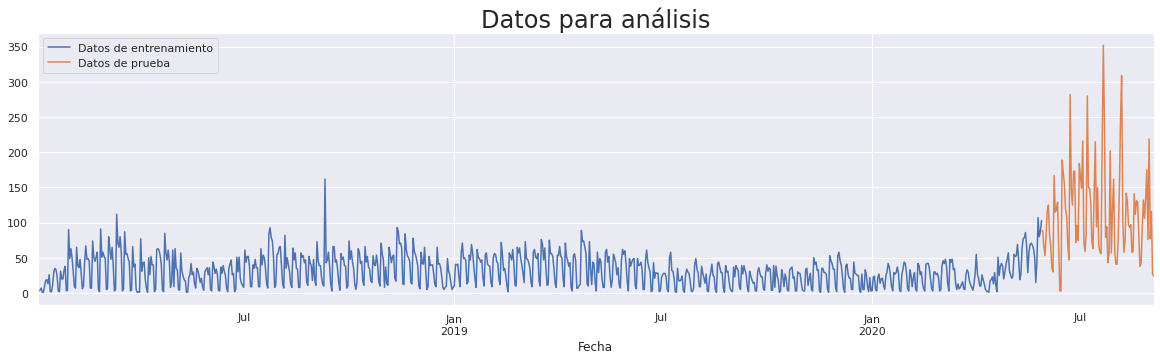

In [28]:
porcentajeEntrenamiento = 0.9
size = int(len(df_comp)*porcentajeEntrenamiento)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

df.analizedValue.plot(figsize = (20,5), label='Datos de entrenamiento')
df_test.analizedValue.plot(figsize = (20,5), label='Datos de prueba')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

## Análisis de serie temporal 

### Prueba de estacionariedad

In [29]:
sts.adfuller(df.analizedValue)

(-2.049986755112007,
 0.2650945039891832,
 21,
 856,
 {'1%': -3.4380124044615803,
  '10%': -2.5685710298388504,
  '5%': -2.8649223608717205},
 6733.528924180784)

**Contraste de hipotesis**

-0.8994044296141788 representa el estadistico que se va a comparar con el valor crítico
 {'1%': -3.437281430175827,
  '10%': -2.5683993544869015,
  '5%': -2.8646000638781532}
Representan los niveles de significacion para cada nivel de confianza.

Como el valor del estadistico es meyor a todos los niveles, no se rechaza la hipotesis nula, **por lo tanto la serie no es estacionaria**

**P valor**

0.7881684842751513 representa el P valor
los niveles de significacion para comparar serían 
0.01
0.10
0.05

Como el P valor es mas alto, no se rechaza la hipotesis nula y se considera que la serie es no estacionaria

### Prueba de estacionalidad

#### Descomposición de aditiva

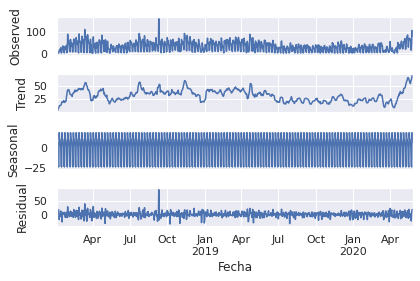

In [31]:
frecuencia = 7

s_dec_additive = seasonal_decompose(df.analizedValue, "additive", freq=frecuencia)
s_dec_additive.plot()
plt.show()

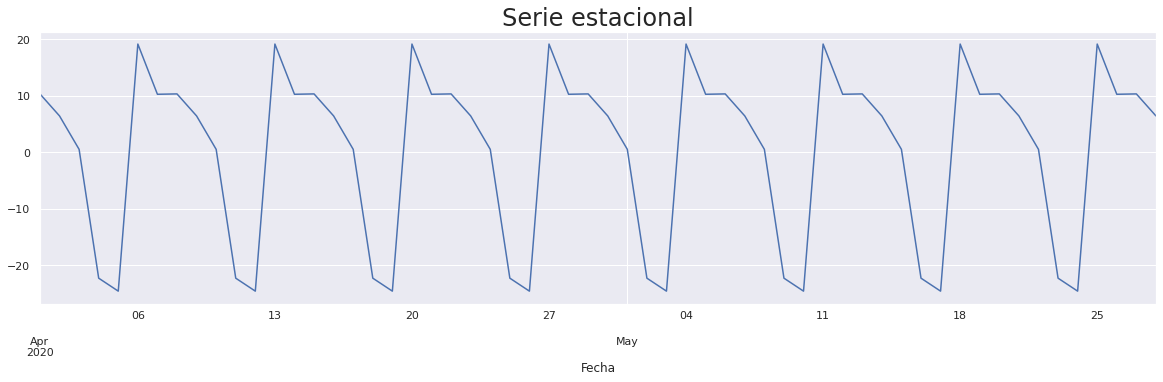

In [41]:
fechaFiltro = '2020-04-01'
s_dec_additive.seasonal[fechaFiltro:].plot(figsize = (20,5))
plt.title("Serie estacional", size= 24)
plt.show()

#### Descomposición multiplicativa

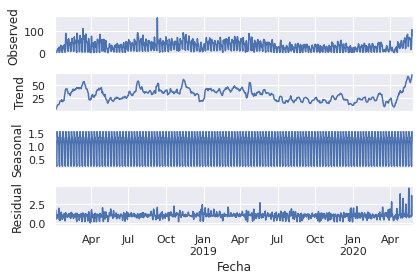

In [43]:
s_dec_multiplicative = seasonal_decompose(df.analizedValue, "multiplicative", freq=7)
s_dec_multiplicative.plot()
plt.show()

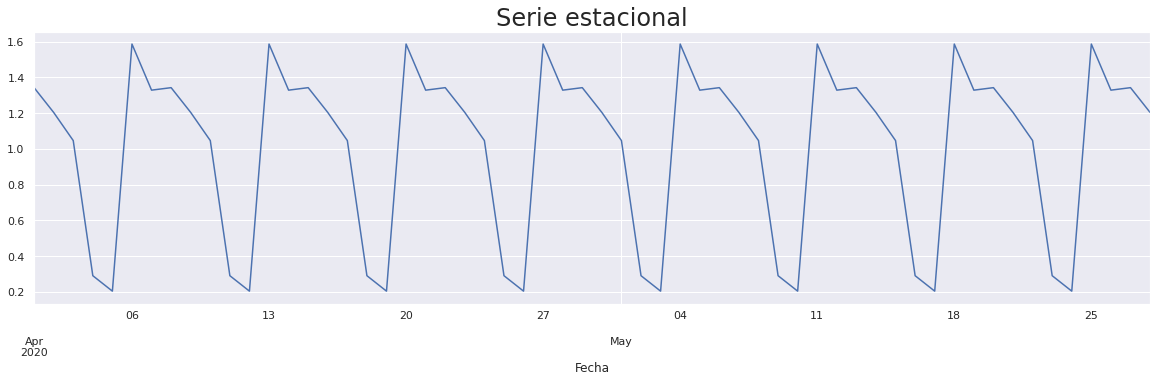

In [44]:
fechaFiltro = '2020-04-01'
s_dec_multiplicative.seasonal[fechaFiltro:].plot(figsize = (20,5))
plt.title("Serie estacional", size= 24)
plt.show()

## Suavizado de serie temporal

### Filtro Hodrick Prescott

In [46]:
from statsmodels.tsa.filters.hp_filter import hpfilter
lambdaValue = 3888000
factorFrecuenciaDiario = 1
factorFrecuenciaMensual = 30

gdp_cycle, gdp_trend = hpfilter(df['analizedValue'], lamb=lambdaValue/factorFrecuenciaMensual)
df['tendencia mensual'] = gdp_trend
gdp_cycle, gdp_trend = hpfilter(df['analizedValue'], lamb=lambdaValue/factorFrecuenciaDiario)
df['tendencia diaria'] = gdp_trend
df.head()

,analizedValue,tendencia mensual,tendencia diaria
Fecha,,,
2018-01-02,2.0,9.617147,25.195130
2018-01-03,3.0,10.388615,25.349989
2018-01-04,4.0,11.160024,25.504843
2018-01-05,7.0,11.931258,25.659678
2018-01-06,1.0,12.702147,25.814479


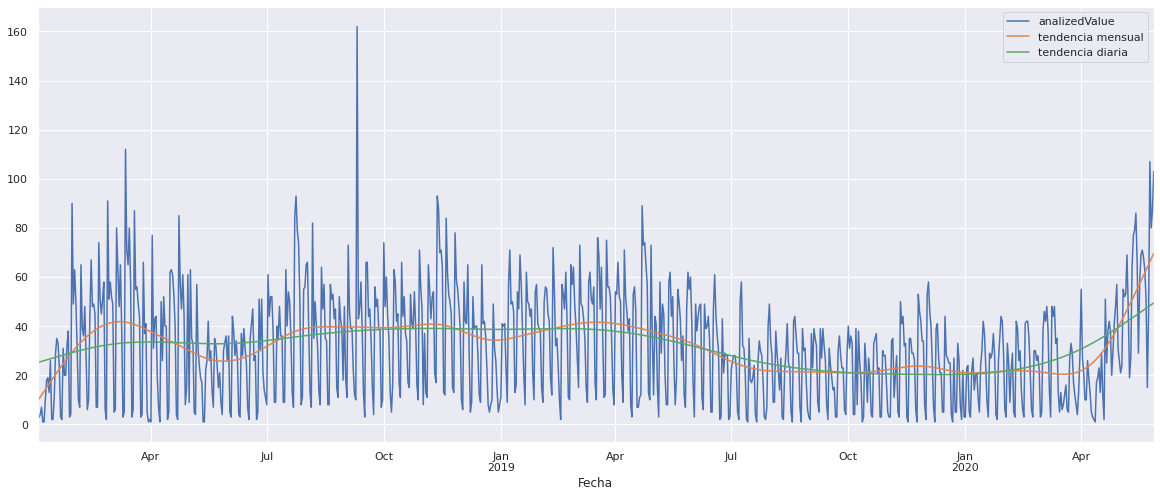

In [48]:
df[['analizedValue','tendencia mensual', 'tendencia diaria']].plot(figsize=(20,8))

### Suavizado con medias móviles

#### Promedio móvil simple

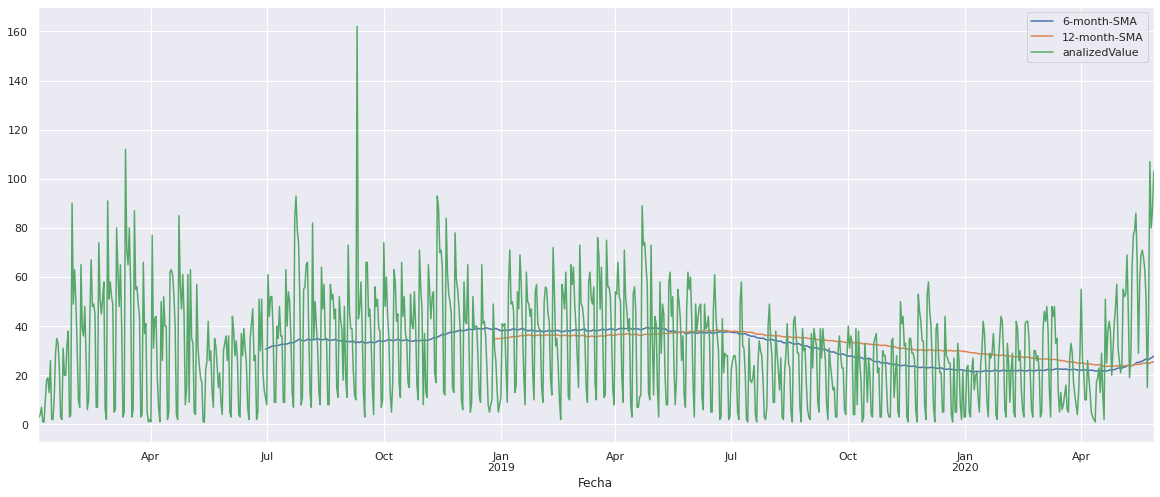

In [50]:
ventanaMensual = 30

df['6-month-SMA'] = df['analizedValue'].rolling(window=ventanaMensual*6).mean()
df['12-month-SMA'] = df['analizedValue'].rolling(window=ventanaMensual*12).mean()
df[['6-month-SMA','12-month-SMA', 'analizedValue']].plot(figsize=(20,8));

#### EWMA

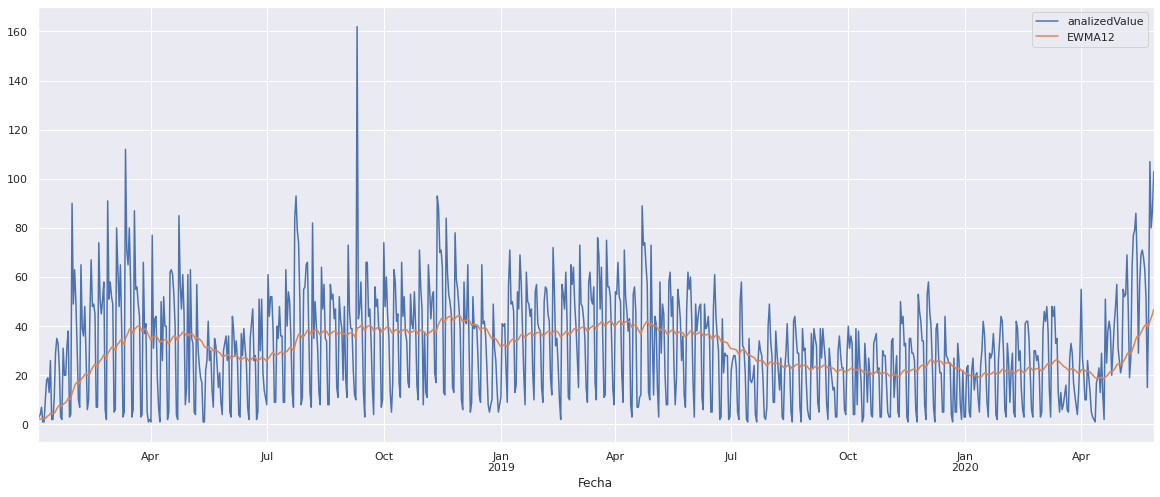

In [52]:
df['EWMA12'] = df['analizedValue'].ewm(span=60,adjust=False).mean()
df[['analizedValue','EWMA12']].plot(figsize=(20,8));

### Suavizado exponencial

#### Simple

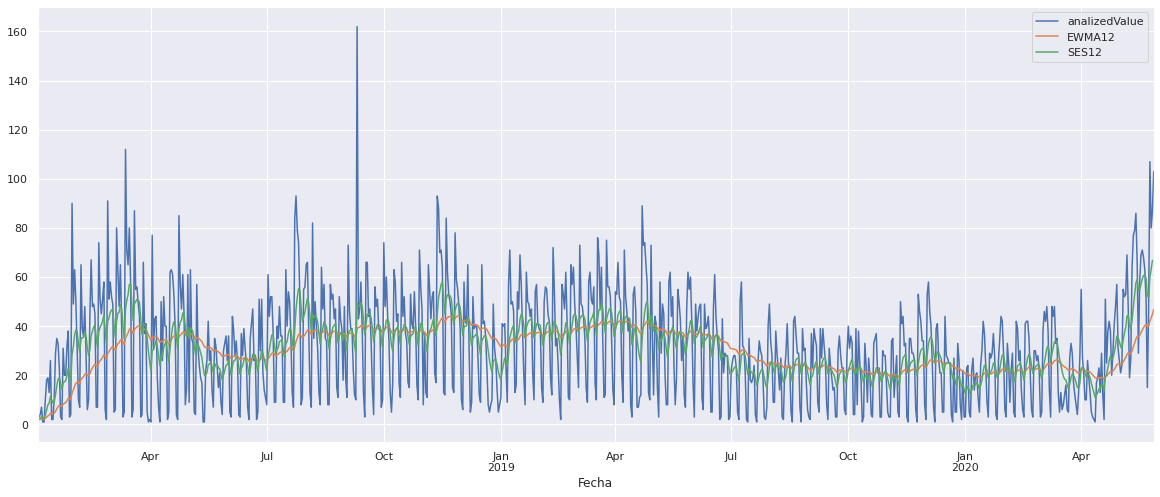

In [56]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
span = 12
alpha = 2/(span+1)
df['SES12']=SimpleExpSmoothing(df['analizedValue']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)

df[['analizedValue','EWMA12','SES12']].plot(figsize=(20,8)).autoscale(axis='x',tight=True);

#### Doble

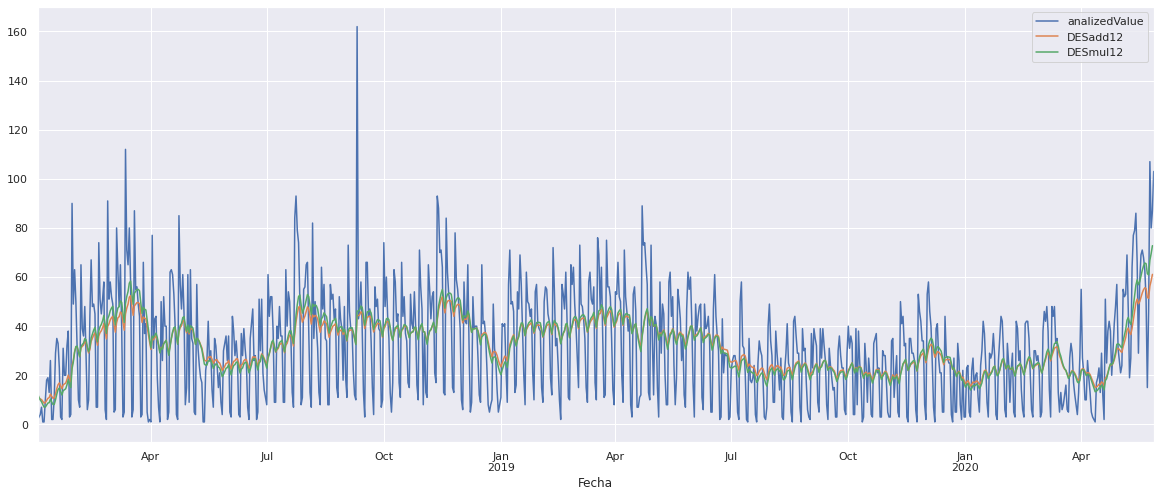

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
## aditivo
df['DESadd12'] = ExponentialSmoothing(df['analizedValue'], trend = 'add').fit().fittedvalues.shift(-1)
## multiplicativo
df['DESmul12'] = ExponentialSmoothing(df['analizedValue'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

df[['analizedValue','DESadd12','DESmul12']].plot(figsize=(20,8)).autoscale(axis='x',tight=True);

#### Triple

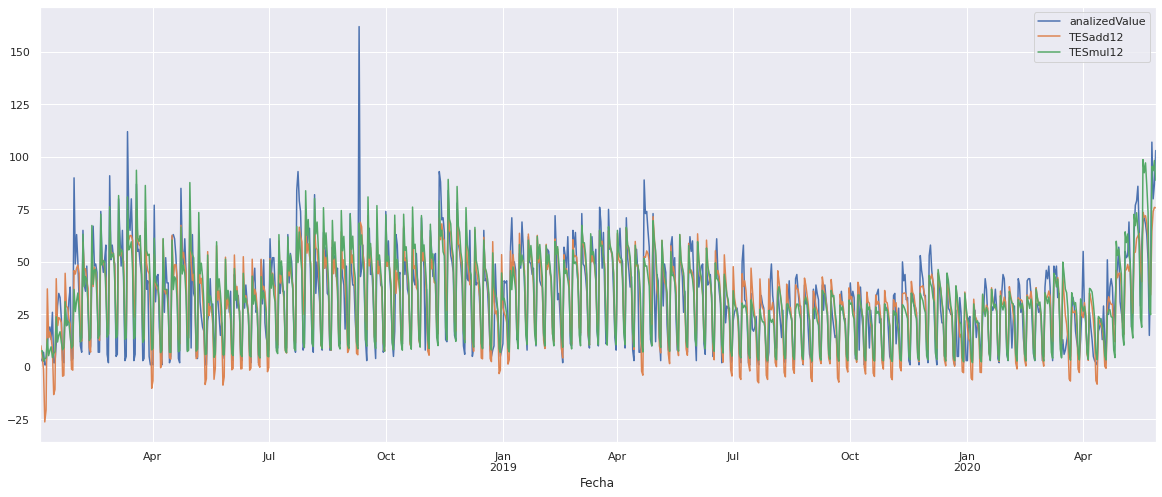

In [60]:
frecuencia = 7 # semanal
# aditivo
df['TESadd12'] = ExponentialSmoothing(df['analizedValue'],trend='add',seasonal='add',seasonal_periods=frecuencia).fit().fittedvalues
# multiplicativo
df['TESmul12'] = ExponentialSmoothing(df['analizedValue'],trend='mul',seasonal='mul',seasonal_periods=frecuencia).fit().fittedvalues

df[['analizedValue','TESadd12','TESmul12']].plot(figsize=(20,8));

## Predicciones

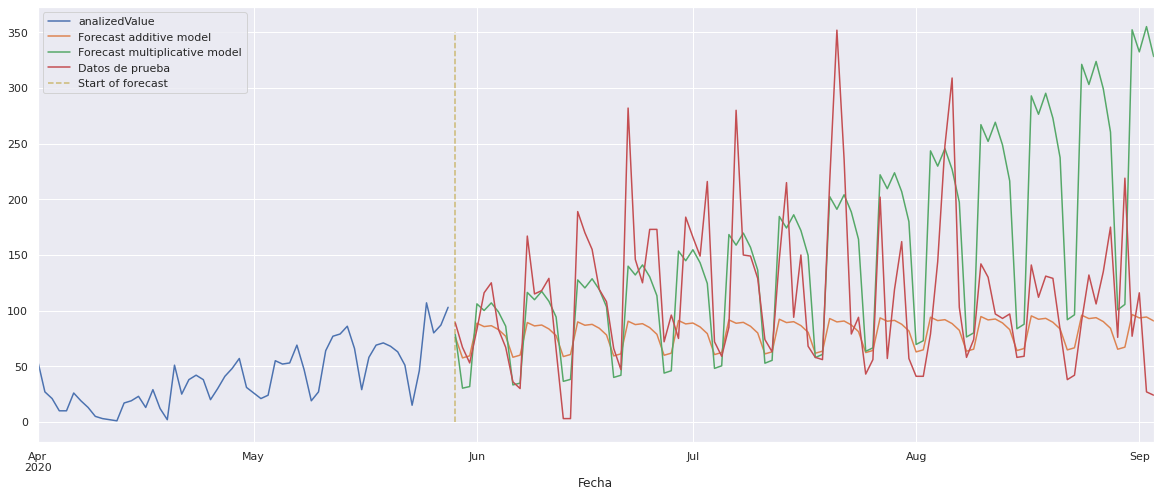

In [69]:
frecuencia = 7
# modelos predictivos
model_add = ExponentialSmoothing(df['analizedValue'],trend='add',seasonal='add',seasonal_periods=frecuencia).fit()
model_mul = ExponentialSmoothing(df['analizedValue'],trend='mul',seasonal='mul',seasonal_periods=frecuencia).fit()

# prediccion de 30 dias
forecast_add = model_add.forecast(len(df_test))
forecast_mul= model_mul.forecast(len(df_test))

df['analizedValue']['2020-04-01':].plot(figsize=(20,8))
forecast_add.plot(label='Forecast additive model');
forecast_mul.plot(label='Forecast multiplicative model');
df_test.analizedValue.plot(label='Datos de prueba');
plt.vlines('2020-05-29', 0, 350, linestyle='--', color='y', label='Start of forecast');
plt.legend(loc='upper left')